## Imports

In [1]:
#Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px # this is another plotting library for interactive plot

from sklearn.model_selection import train_test_split
from sklearn import metrics, manifold # we will use the metrics and manifold learning modules from scikit-learn
from pathlib import Path # to interact with file paths
from PIL import Image # to interact with images
from tqdm import tqdm # progress bar
from pprint import pprint # pretty print (useful for a more readable print of objects like lists or dictionaries)
from IPython.display import clear_output # to clear the output of the notebook

import torch
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import os
import shutil


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")

cuda


In [2]:
# CONTROL
num_channels = 1
SIZE = (240, 240)
model_name = 'models/sign_finder.pt'
onnx_sign_finder_path = "models/sign_finder.onnx"
max_load = 1_000 

In [3]:
# LOAD EXAMPLES
# imgs of the examples must be in a specific folder (ex: sign_imgs), and must be named as "class_<number>.png"
# ex: sign_imgs/stop_1.png, note: start from 1

#load examples
examples_folder = 'sign_imgs'     
# class_names = ['park', 'closedroad', 'highwayexit', 'highwayenter', 'stop', 'roundabout', 'priority', 'crosswalk', 'oneway', 'nosign']
class_names = ['park', 'closedroad', 'highwayexit', 'highwayenter', 'stop', 'roundabout', 'priority', 'crosswalk', 'oneway']

file_names = [f for f in os.listdir(examples_folder) if f.endswith('.png')]
example_labels = [class_names.index(name.split('_')[0]) for name in file_names if name.split('_')[0] in class_names]
example_imgs = [cv.imread(os.path.join(examples_folder, name), cv.IMREAD_GRAYSCALE) for name in file_names if name.split('_')[0] in class_names]
tot_examples = len(example_imgs)
tot_classes = len(class_names) 
print(f'{tot_examples} examples loaded for {tot_classes} class_names')
print(f'example labels: {example_labels}')    

#show images
cv.namedWindow('example', cv.WINDOW_NORMAL)
for i in range(tot_examples):
    img = example_imgs[i].copy()
    # add text label
    cv.putText(img, class_names[example_labels[i]], (10,30), cv.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv.imshow('example', img)
    key = cv.waitKey(1)
    if key == 27:
        break
cv.destroyAllWindows()     

9 examples loaded for 9 class_names
example labels: [7, 5, 6, 1, 4, 8, 0, 2, 3]


## Load Pretrained Net and create Detector 

In [4]:
# NETWORK ARCHITECTURE

class SignFinder(nn.Module):
    def __init__(self, out_dim=4, channels=1): 
        super().__init__()
        ### Convoluational layers
        self.conv = nn.Sequential( #in = (SIZE) = 240, 240
            nn.Conv2d(channels, 16, kernel_size=8, stride=2), #out = 117
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2), #out=58
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 4, kernel_size=6, stride=2), #out = 27
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2), #out=13
            # nn.BatchNorm2d(4),
            nn.Conv2d(4, 4, kernel_size=5, stride=2), #out = 5
            nn.ReLU(True),
        )
        self.flat = nn.Flatten()
        ### Linear sections
        self.lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=5*5*4, out_features=16),
            nn.ReLU(True),
            nn.Linear(in_features=16, out_features=out_dim),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.lin(x)
        return x

sign_finder = SignFinder(out_dim=3+tot_classes,channels=num_channels).to(device)

In [5]:
# TEST NET INPUTS/OUTPUTS
#show the image with opencv
img = cv.imread('tests/test_img.jpg')
img = cv.resize(img, SIZE)
if num_channels == 1:
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = np.expand_dims(img, axis=2)
#convert to tensor
img = torch.from_numpy(img).float()
img = img.permute(2,0,1)
#add dimension
img = img.unsqueeze(0).to(device)
print(img.shape)

sign_finder.eval()

# Inference
with torch.no_grad():
    output = sign_finder(img)
    print(f'out shape: {output.shape}')

torch.Size([1, 1, 240, 240])
out shape: torch.Size([1, 12])


## Loading images and Labels

In [6]:
# IMG LOADER AND AUGMENTATION
import cv2 as cv
import numpy as np
from numpy.random import randint

def draw_box(img, x, y, w):
    img = cv.rectangle(img, (int(x-w/2), int(y-w/2)), (int(x+w/2), int(y+w/2)), 255, 2)
    return img

def load_and_augment_img(img, example_index=0, example_imgs=example_imgs):
    # img = cv.imread(os.path.join(folder, f'img_{i+1}.png'))

    #convert to gray
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #crop to the top right quadrant
    img = img[:SIZE[0], -SIZE[1]:]
    assert img.shape == SIZE

    ## EXAMPLE AUGMENTATION ##############################################################
    #load example
    example = example_imgs[example_index]
    resize_ratio = max(img.shape)/max(example.shape[0], example.shape[1])
    example = cv.resize(example, (int(example.shape[1]*resize_ratio), int(example.shape[0]*resize_ratio)))
    
    # #flip
    # if np.random.uniform() < 0.5:
    #     example = cv.flip(example, 1)

    #get example mask
    example_mask = np.where(example == 0, np.zeros_like(example), 255*np.ones_like(example))
    #blur the example
    example = cv.blur(example, (randint(3,9),randint(3,9)))

    #add noise to the example
    std = 100
    std = randint(1, std)
    noisem = randint(0, std, example.shape, dtype=np.uint8)
    example = cv.subtract(example, noisem)
    noisep = randint(0, std, example.shape, dtype=np.uint8)
    example = cv.add(example, noisep)

    #dilate
    kernel = np.ones((randint(3,7),randint(3,7)), np.uint8)
    example = cv.dilate(example, kernel, iterations=1)

    #set zero where example mask is zero
    example = np.where(example_mask == 0, np.zeros_like(example), example)
    # cv.imshow('test', example)

    # #random rotation
    # angle = randint(-10,10)
    # M = cv.getRotationMatrix2D((example.shape[1]/2, example.shape[0]/2), angle, 1)
    # example = cv.warpAffine(example, M, (example.shape[1], example.shape[0]))

    #perspective transform example
    perspective_deformation = 30
    pts1 = np.float32([[0,0],[example.shape[1],0],[example.shape[1],example.shape[0]],[0,example.shape[0]]])
    pts2 = np.float32([[0,0],[example.shape[1],0],[example.shape[1],example.shape[0]],[0,example.shape[0]]])
    pts2 = pts2 + np.float32(randint(0,perspective_deformation,size=pts2.shape))
    # print(f'pts2 = \n{pts2}')
    new_size_x = int(np.max(pts2[:,0]) - np.min(pts2[:,0]))
    new_size_y = int(np.max(pts2[:,1]) - np.min(pts2[:,1]))
    M = cv.getPerspectiveTransform(pts1,pts2)
    example = cv.warpPerspective(example,M,(new_size_x,new_size_y))

    #resize example keeping proportions
    img_example_ratio = min(img.shape[0]/example.shape[0], img.shape[1]/example.shape[1])
    scale_factor = np.random.uniform(.95, .99) ##.15, .35############################ PARAM ##############################
    scale_factor = scale_factor * img_example_ratio
    example = cv.resize(example, (0,0), fx=scale_factor, fy=scale_factor)
    #match img shape
    example_canvas = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    #get a random position for the example
    example_y = randint(0, img.shape[0] - example.shape[0])
    example_x = randint(0, img.shape[1] - example.shape[1])
    #paste example on canvas
    example_canvas[example_y:example_y+example.shape[0], example_x:example_x+example.shape[1]] = example

    #generate label for example
    x_lab = example_x + example.shape[1]/2
    y_lab = example_y + example.shape[0]/2
    w_lab = max(example.shape[0], example.shape[1])
    box = [x_lab, y_lab, w_lab]

    old_example_canvas = example_canvas.copy()
    
    #reduce contrast
    const = np.random.uniform(0.4,1)
    example_canvas = 127*(1-const) + example_canvas*const
    #clip values
    example_canvas = np.clip(example_canvas, 0, 255).astype(np.uint8)

    #paste canvas on img
    img = np.where(old_example_canvas > 0, example_canvas, img) 
    example_canvas = cv.blur(example_canvas, (randint(1,7),randint(1,7)))
    ##########################################################################################

    # #create random ellipses to simulate light from the sun
    # light = np.zeros(img.shape, dtype=np.uint8)
    # #add ellipses
    # for j in range(2):
    #     cent = (np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1]))
    #     axes_length = (np.random.randint(10, 50), np.random.randint(50, 300))
    #     angle = np.random.randint(0, 360)
    #     light = cv.ellipse(light, cent, axes_length, angle, 0, 360, 255, -1)
    # #create an image of random white and black pixels
    # light = cv.blur(light, (100,100))
    # noise = np.random.randint(0, 2, size=img.shape, dtype=np.uint8)*255
    # light = cv.subtract(light, noise)
    # light = 5 * light
    # #add light to the image
    # img = cv.add(img, light)

    #blur the image
    # img = cv.blur(img, (9,9))
    img = cv.blur(img, (randint(1,3), randint(1,3)))

    # # cut the top third of the image, let it 640x320
    # img = img[int(img.shape[0]/3):,:] ################################# /3
    # # assert img.shape == (320,640), f'img shape cut = {img.shape}'
    # #resize 
    # img = cv.resize(img, SIZE)

    # #add random tilt
    # max_offset = 5
    # offset = np.random.randint(-max_offset, max_offset)
    # img = np.roll(img, offset, axis=0)
    # if offset > 0:
    #     img[:offset, :] = np.random.randint(0,255)
    # elif offset < 0:
    #     img[offset:, :] = np.random.randint(0,255)

    #reduce contrast
    const = np.random.uniform(0.1,1.0)
    if np.random.uniform() > 5:
        const = const*0.2
    img = 127*(1-const) + img*const
    img = img.astype(np.uint8)

    #add noise 
    std = 80
    std = np.random.randint(1, std)
    noisem = np.random.randint(0, std, img.shape, dtype=np.uint8)
    img = cv.subtract(img, noisem)
    noisep = np.random.randint(0, std, img.shape, dtype=np.uint8)
    img = cv.add(img, noisep)
    #blur 
    img = cv.blur(img, (np.random.randint(1,3),np.random.randint(1,3)))

    #add random brightness
    max_brightness = 50
    brightness = np.random.randint(-max_brightness, max_brightness)
    if brightness > 0:
        img = cv.add(img, brightness)
    elif brightness < 0:
        img = cv.subtract(img, -brightness)
    
    # # invert color
    # if np.random.uniform(0, 1) > 0.6:
    #     img = cv.bitwise_not(img)

    return img, box


cv.namedWindow('img', cv.WINDOW_NORMAL)
# cv.setWindowProperty('img', cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN)

for i in range(500):
    img = cv.imread(os.path.join('training_imgs', f'img_{i+1}.png'))
    img, box = load_and_augment_img(img, example_index=(i%tot_examples))
    x,y,w = box
    img = draw_box(img, x, y, w)

    cv.imshow('img', img)
    key = cv.waitKey(150)
    if key == ord('q') or key == 27:
        break
cv.destroyAllWindows()

In [7]:
# DATASET CLASS
class CsvDataset(Dataset):
    def __init__(self, folder, transform=None, max_load=1000, channels=3):
        self.transform = transform
        self.folder = folder
        self.data = []
        self.class_names = []
        self.channels = channels

        with open(folder+'/regression_labels.csv', 'r') as f:
            lines = f.read().split('\n')
            lines = lines[0:-1] #remove footer
            # Get x and y values from each line and append to self.data
            max_load = min(max_load, len(lines))
            # self.all_imgs = torch.zeros((2*max_load, SIZE[1], SIZE[0], channels), dtype=torch.uint8) #adding flipped img
            self.all_imgs = torch.zeros((max_load, SIZE[1], SIZE[0], channels), dtype=torch.uint8)

            cv.namedWindow('img', cv.WINDOW_NORMAL)
            # cv.setWindowProperty('img', cv.WND_PROP_FULLSCREEN, cv.WINDOW_FULLSCREEN

            for i in tqdm(range(max_load)):
                img = cv.imread(os.path.join(folder, f'img_{i+1}.png'))
                img, box = load_and_augment_img(img, example_index=(i%tot_examples))
                box = np.array(box) #box = x,y,w
                #convert box to float32
                box = box.astype(np.float32)
                if i < 100:
                    cv.imshow('img', img)
                    cv.waitKey(1)
                    if i == 99:
                        cv.destroyAllWindows()
                #add a dimension to the image
                img = img[:, :,np.newaxis]
                self.all_imgs[i] = torch.from_numpy(img)
                self.data.append(box)
                self.class_names.append(example_labels[i%tot_examples])
            
            self.data = torch.from_numpy(np.array(self.data))
            self.class_names = torch.from_numpy(np.array(self.class_names))
            print(f'\nall imgs: {self.all_imgs.shape}')
            print(f'data: {self.data.shape}')
            print(f'class_names: {self.class_names.shape}')


    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # img = read_image(os.path.join(self.folder, f'img_{idx+1}.png'))
        # img = img.float()
        img = self.all_imgs[idx]
        img = img.permute(2, 0, 1).float()
        value = self.data[idx]
        class_label = self.class_names[idx]
        return img, value, class_label

In [8]:
#create dataset #takes a long time but then training is faster
train_dataset = CsvDataset('training_imgs', max_load=max_load, channels=num_channels)
#split dataset into train and val
train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

100%|██████████| 1000/1000 [00:10<00:00, 92.33it/s]


all imgs: torch.Size([1000, 240, 240, 1])
data: torch.Size([1000, 3])
class_names: torch.Size([1000])


In [9]:
#data loader
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=True)

In [10]:
#test dataloader
sample = next(iter(train_dataloader))
print(sample[0].shape)
print(sample[1].shape)

torch.Size([100, 1, 240, 240])
torch.Size([100, 3])


## Training

In [11]:
# TRAINING FUNCTION
def train_epoch(model, dataloader, regr_loss_fn, class_loss_fn, optimizer, L1_lambda=0.0, L2_lambda=0.0,  device=device):
    # Set the model to training mode
    model.train() #train
    # Initialize the loss
    x_losses = []
    y_losses = []
    w_losses = []
    class_losses = []

    # Loop over the training batches
    for (input, box_label, class_label) in tqdm(dataloader):
        #one hot encode the class label
        class_label = torch.eye(tot_classes)[class_label]
        # Move the input and target data to the selected device
        input, box_label, class_label = input.to(device), box_label.to(device), class_label.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Compute the output
        output = model(input)

        #regression
        x_out = output[:, 0]
        y_out = output[:, 1]
        w_out = output[:, 2]
        class_out = output[:, 3:]

        x_label = box_label[:, 0]
        y_label = box_label[:, 1]
        w_label = box_label[:, 2]

        # Compute the losses
        x_loss = .0*regr_loss_fn(x_out, x_label)
        y_loss = .0*regr_loss_fn(y_out, y_label)
        w_loss = .0*regr_loss_fn(w_out, w_label)

        #classification loss
        assert class_label.shape == class_out.shape, f'class_label.shape: {class_label.shape}, output.shape: {output.shape}'
        class_loss = 1.0*class_loss_fn(class_out, class_label)

        # #L1 regularization
        # L1_norm = sum(p.abs().sum() for p in model.conv.parameters())
        # L1_loss = L1_lambda * L1_norm 
        # #L2 regularization
        # L2_norm = sum(p.pow(2).sum() for p in model.conv.parameters())
        # L2_loss = L2_lambda * L2_norm

        loss = y_loss + x_loss + w_loss + class_loss# + L1_loss + L2_loss

        # Compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()

        #batch loss
        x_losses.append(x_loss.detach().cpu().numpy())
        y_losses.append(y_loss.detach().cpu().numpy())
        w_losses.append(w_loss.detach().cpu().numpy())
        class_losses.append(class_loss.detach().cpu().numpy())

    # Return the average training loss
    x_loss = np.mean(x_losses)
    y_loss = np.mean(y_losses)
    w_loss = np.mean(w_losses)
    class_loss = np.mean(class_losses)
    return  np.sqrt(x_loss),  np.sqrt(y_loss),  np.sqrt(w_loss), np.sqrt(class_loss)

    # VALIDATION FUNCTION
def val_epoch(sign_finder, val_dataloader, regr_loss_fn, class_loss_fn, device=device):
    sign_finder.eval()
    y_losses = []
    x_losses = []
    w_losses = []
    class_losses = []
    for (input, box_label, class_label) in tqdm(val_dataloader):
        #one hot encode the class label
        class_label = torch.eye(tot_classes)[class_label]
        input, box_label, class_label = input.to(device), box_label.to(device), class_label.to(device)
        output = sign_finder(input)

        regr_out = output
        x_out = regr_out[:, 0]
        y_out = regr_out[:, 1]
        w_out = regr_out[:, 2]

        x_label = box_label[:, 0]
        y_label = box_label[:, 1]
        w_label = box_label[:, 2]

        y_loss = 1.0*regr_loss_fn(y_out, y_label)
        x_loss = 1.0*regr_loss_fn(x_out, x_label)
        w_loss = 1.0*regr_loss_fn(w_out, w_label)

        class_loss = 1.0*class_loss_fn(output[:, 3:], class_label)
        
        x_losses.append(x_loss.detach().cpu().numpy())
        y_losses.append(y_loss.detach().cpu().numpy())
        w_losses.append(w_loss.detach().cpu().numpy())
        class_losses.append(class_loss.detach().cpu().numpy())
    return  np.sqrt(np.mean(x_losses)),  np.sqrt(np.mean(y_losses)),  np.sqrt(np.mean(w_losses)), np.sqrt(np.mean(class_losses))

In [12]:
# TRAINING 
#parameters
lr = 0.009 #0.005
epochs = 50
#regularization is applied only to convolutional section, add weight decay to apply it to all layers
L1_lambda = 0.0 #9e-4
L2_lambda = 0.0 #1e-2
optimizer = torch.optim.Adam(sign_finder.parameters(), lr=lr, weight_decay=0.0) #wd = 2e-3# 9e-5

regr_loss_fn = nn.MSELoss()
class_loss_fn = nn.CrossEntropyLoss()
for epoch in range(epochs):
    # try:
    if True:
        x_loss, y_loss, w_loss, class_loss = train_epoch(sign_finder, train_dataloader, regr_loss_fn, class_loss_fn, optimizer, L1_lambda, L2_lambda, device)
        val_x_loss, val_y_loss, val_w_loss, val_class_loss = val_epoch(sign_finder, val_dataloader, regr_loss_fn, class_loss_fn, device)
        clear_output(wait=True)
    # except Exception as e:
    #     print(e)
    #     torch.cuda.empty_cache()
    #     continue
    print(f"Epoch  {epoch+1}/{epochs} -> \nx_loss: {x_loss:.4f} --- Val: {val_x_loss:.4f}")
    print(f"y_loss: {y_loss:.4f} --- Val: {val_y_loss:.4f}")
    print(f"w_loss: {w_loss:.4f} --- Val: {val_w_loss:.4f}")
    print(f"class_loss: {class_loss:.4f} --- Val: {val_class_loss:.4f}")
    torch.save(sign_finder.state_dict(), model_name)



Epoch  15/50 -> 
x_loss: 0.0000 --- Val: 123.0008
y_loss: 0.0000 --- Val: 112.8462
w_loss: 0.0000 --- Val: 236.8105
class_loss: 0.3070 --- Val: 0.4518


 78%|███████▊  | 7/9 [00:00<00:00,  7.32it/s]


KeyboardInterrupt: 

In [20]:
# EVALUATE ON TEST SET (UNSEEN DATA)
val_dataloader2 = DataLoader(val_dataset, batch_size=1, shuffle=False)
sign_finder.load_state_dict(torch.load(model_name))
sign_finder.eval()
for (input, box_label, class_label) in tqdm(val_dataloader2):
    #convert img to numpy array
    img = input[0].detach().cpu().numpy()[0]
    #convert to sigle byte
    img = img.astype(np.uint8)
    input, box_label, class_label =input.to(device), box_label.to(device), class_label.to(device)
    output = sign_finder(input)
    x = output[:, 0]
    y = output[:, 1]
    w = output[:, 2]
    class_out = output[:, 3:]
    # print(class_out)
    class_out = torch.argmax(class_out, dim=1)
    class_out = class_out.detach().cpu().numpy()
    # print(f"Predicted class: {class_out[0]}, Actual class: {class_label[0]}")
    class_out = class_out[0]
    class_out = class_names[class_out]
    true_class = class_names[class_label[0]]
    img = draw_box(img, x, y, w)
    #text for labels
    img = cv.putText(img, f"True: {true_class}", (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    img = cv.putText(img, f"Pred: {class_out}", (10, 60), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv.imshow('img', img)
    key = cv.waitKey(0)
    if key == 27:
        break
    
cv.destroyAllWindows()


  0%|          | 0/100 [00:01<?, ?it/s]


(16, 1, 8, 8)
(4, 16, 6, 6)
(4, 4, 5, 5)


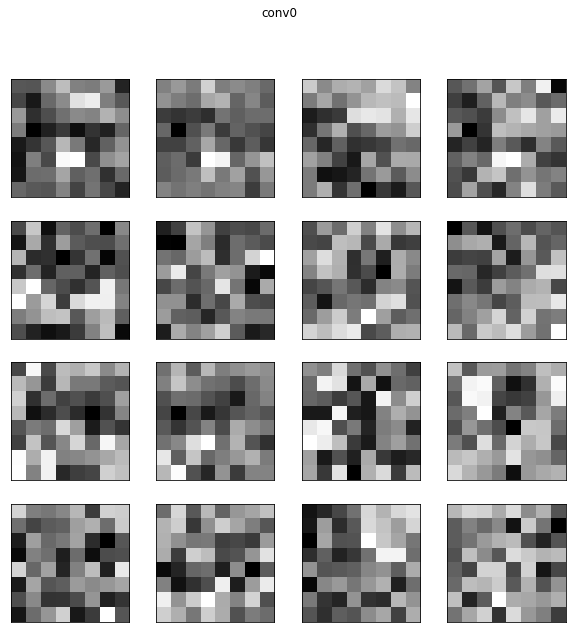

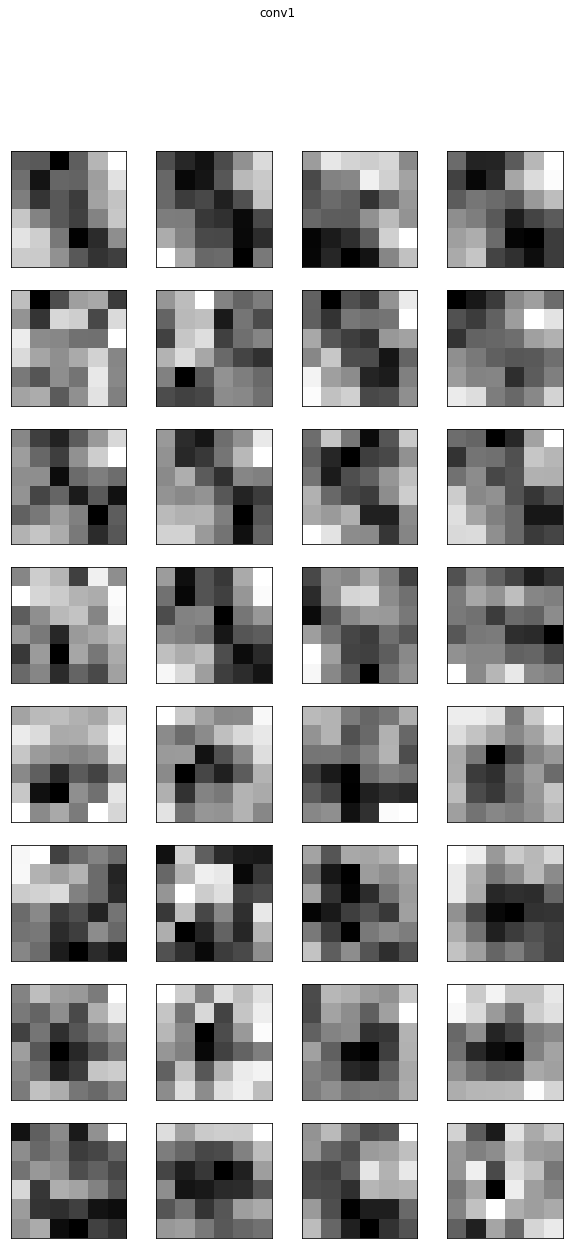

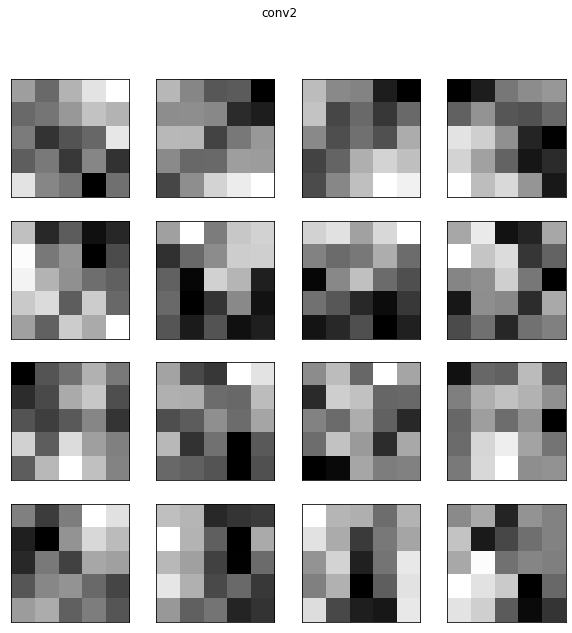

In [17]:
# VISUALIZE CONVOLUTIONAL FILTERS
conv_layers = []
children = list(sign_finder.children())
for i in range(len(children)):
    if isinstance(children[i], nn.Conv2d):
        conv_layers.append(children[i])
    elif isinstance(children[i], nn.Sequential):
        for child in children[i].children():
            if isinstance(child, nn.Conv2d):
                conv_layers.append(child)

c0 = conv_layers[0].weight.data.cpu().numpy()
c1 = conv_layers[1].weight.data.cpu().numpy()
c2 = conv_layers[2].weight.data.cpu().numpy()

def plot_nchw_data(data, h_num, v_num, title, size=(10, 10)):
    fig, axs = plt.subplots(h_num, v_num, figsize=size)
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    #plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()
    return fig

# fig0 = plot_nchw_data(c0, 4, 4, 'conv0')
print(c0.shape)
print(c1.shape)
print(c2.shape)

fig0 = plot_nchw_data(c0, 4, 4, 'conv0', size=(10,10))

fig1 = plot_nchw_data(c1, 8, 4, 'conv1', size=(10,20)) 

fig2 = plot_nchw_data(c2, 4, 4, 'conv2', size=(10,10))



In [18]:
# CONVERT TO ONNX MODEL FOR OPENCV
sign_finder.load_state_dict(torch.load(model_name))

#save the model so that opencv can load it
import torch
import torch.onnx
import torchvision
import torchvision.models as models
import sys

device = torch.device('cpu')
sign_finder.to(device)

# set the model to inference mode
sign_finder.eval()

# Create some sample input in the shape this model expects 
# This is needed because the convertion forward pass the network once 
dummy_input = torch.randn(1, num_channels, SIZE[1], SIZE[0])
torch.onnx.export(sign_finder, dummy_input, onnx_sign_finder_path, verbose=True)

clear_output(wait=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sign_finder.to(device)

SignFinder(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(8, 8), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 4, kernel_size=(6, 6), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(4, 4, kernel_size=(5, 5), stride=(2, 2))
    (8): ReLU(inplace=True)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin): Sequential(
    (0): Linear(in_features=100, out_features=16, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=16, out_features=12, bias=True)
  )
)

In [19]:
# TEST WITH OPENCV
sample_image = "training_imgs/img_1.png"
images = [cv.imread(f"training_imgs/img_{i+1}.png") for i in range(100)]
 
#The Magic:
lk =  cv.dnn.readNetFromONNX(onnx_sign_finder_path) 

avg_col = (0,0,0) if num_channels == 3 else 0

for i in tqdm(range(100)):
    image = images[i]
    image = cv.resize(image, SIZE)
    if num_channels == 1:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blob = cv.dnn.blobFromImage(image, 1.0, SIZE, avg_col, swapRB=True, crop=False)
    # print(blob.shape)
    lk.setInput(blob)
    preds = lk.forward()
    # print(f"Predictions: {preds[0][2]}")

print(f"Predictions: {preds}")
print(f"Predictions shape: {preds.shape}")

100%|██████████| 100/100 [00:00<00:00, 377.30it/s]

Predictions: [[  4.0031753 -43.43267   -10.982186  -66.011765  -37.72751    11.57509
   21.777205  -67.27822    34.198833  -73.45145    -8.973366   -9.533742 ]]
Predictions shape: (1, 12)
